In [2]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.9 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt # For frequentist change point detection (e.g., PELT)

# For Bayesian Change Point Detection
import pymc as pm
import arviz as az # For plotting and analyzing MCMC results

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = "/content/drive/MyDrive/BrentOilPrices.csv"

try:
    data = pd.read_csv(path)

    # Use format='mixed' to infer the format for each date string
    data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=False)
    data = data.sort_values(by='Date')
    data = data.set_index('Date')

    # Handle missing values by interpolation, as suggested for robust analysis
    # This is crucial for time series data to maintain continuity
    data['Price'] = data['Price'].interpolate(method='time')

    # Drop any rows where 'Price' might still be NaN after interpolation (e.g., at the very beginning/end if no surrounding data)
    data = data.dropna(subset=['Price'])

    # For Bayesian analysis of volatility, it's often better to work with log returns
    # Log returns help in achieving stationarity and are directly related to volatility.
    # We use.diff() and.dropna() to handle the first NaN value from the difference calculation.
    data['Log_Return'] = np.log(data['Price']).diff().dropna()

    # The time series for analysis will be the 'Price' for ruptures and 'Log_Return' for PyMC
    time_series_price = data['Price']
    time_series_log_return = data['Log_Return'].dropna() # Ensure log returns are also dropped if NaN

    print("Brent Oil Prices Time Series Head:")
    display(time_series_price.head())
    print("\nBrent Oil Prices Time Series Tail:")
    display(time_series_price.tail())
    print("\nBrent Oil Log Returns Time Series Head:")
    display(time_series_log_return.head())
    print("\nBrent Oil Log Returns Time Series Tail:")
    display(time_series_log_return.tail())

except FileNotFoundError:
    print(f"Error: The file '{path}' was not found. Please update the 'path' variable with the correct file location.")

except Exception as e:
    print(f"An error occurred during data loading or preprocessing: {e}")


Brent Oil Prices Time Series Head:


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63



Brent Oil Prices Time Series Tail:


,Price
Date,
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37
2022-11-14,93.59



Brent Oil Log Returns Time Series Head:


,Log_Return
Date,
1987-05-21,-0.009709
1987-05-22,0.005405
1987-05-25,0.002692
1987-05-26,0.001612
1987-05-27,-0.001612



Brent Oil Log Returns Time Series Tail:


,Log_Return
Date,
2022-11-08,-0.030706
2022-11-09,-0.040026
2022-11-10,0.012814
2022-11-11,0.022244
2022-11-14,-0.029271


## Frequentist Change Point Detection using ruptures (PELT) on Raw Price


Detected Change Point Indices (ruptures on Price): [65, 145, 190, 225, 270, 330, 390, 415, 465, 510, 605, 660, 705, 735, 805, 820, 840, 850, 855, 870, 875, 880, 890, 905, 925, 935, 955, 1060, 1115, 1155, 1265, 1395, 1550, 1665, 1760, 1805, 1845, 2000, 2060, 2175, 2250, 2270, 2350, 2370, 2475, 2505, 2630, 2675, 2695, 2725, 2805, 2875, 2895, 2920, 3000, 3020, 3075, 3120, 3165, 3210, 3240, 3255, 3285, 3290, 3335, 3355, 3365, 3385, 3420, 3435, 3445, 3460, 3475, 3485, 3535, 3580, 3620, 3640, 3670, 3750, 3765, 3810, 3830, 3870, 3915, 3955, 3990, 4015, 4020, 4030, 4060, 4115, 4140, 4160, 4210, 4260, 4310, 4335, 4355, 4370, 4410, 4420, 4440, 4445, 4465, 4470, 4485, 4520, 4525, 4550, 4575, 4590, 4600, 4630, 4640, 4660, 4680, 4705, 4725, 4740, 4750, 4765, 4790, 4800, 4810, 4815, 4825, 4835, 4865, 4885, 4900, 4910, 4915, 4925, 4975, 4995, 5000, 5010, 5030, 5055, 5090, 5120, 5145, 5165, 5190, 5200, 5205, 5225, 5240, 5255, 5275, 5285, 5290, 5300, 5310, 5315, 5320, 5330, 5335, 5345, 5355, 5370, 538

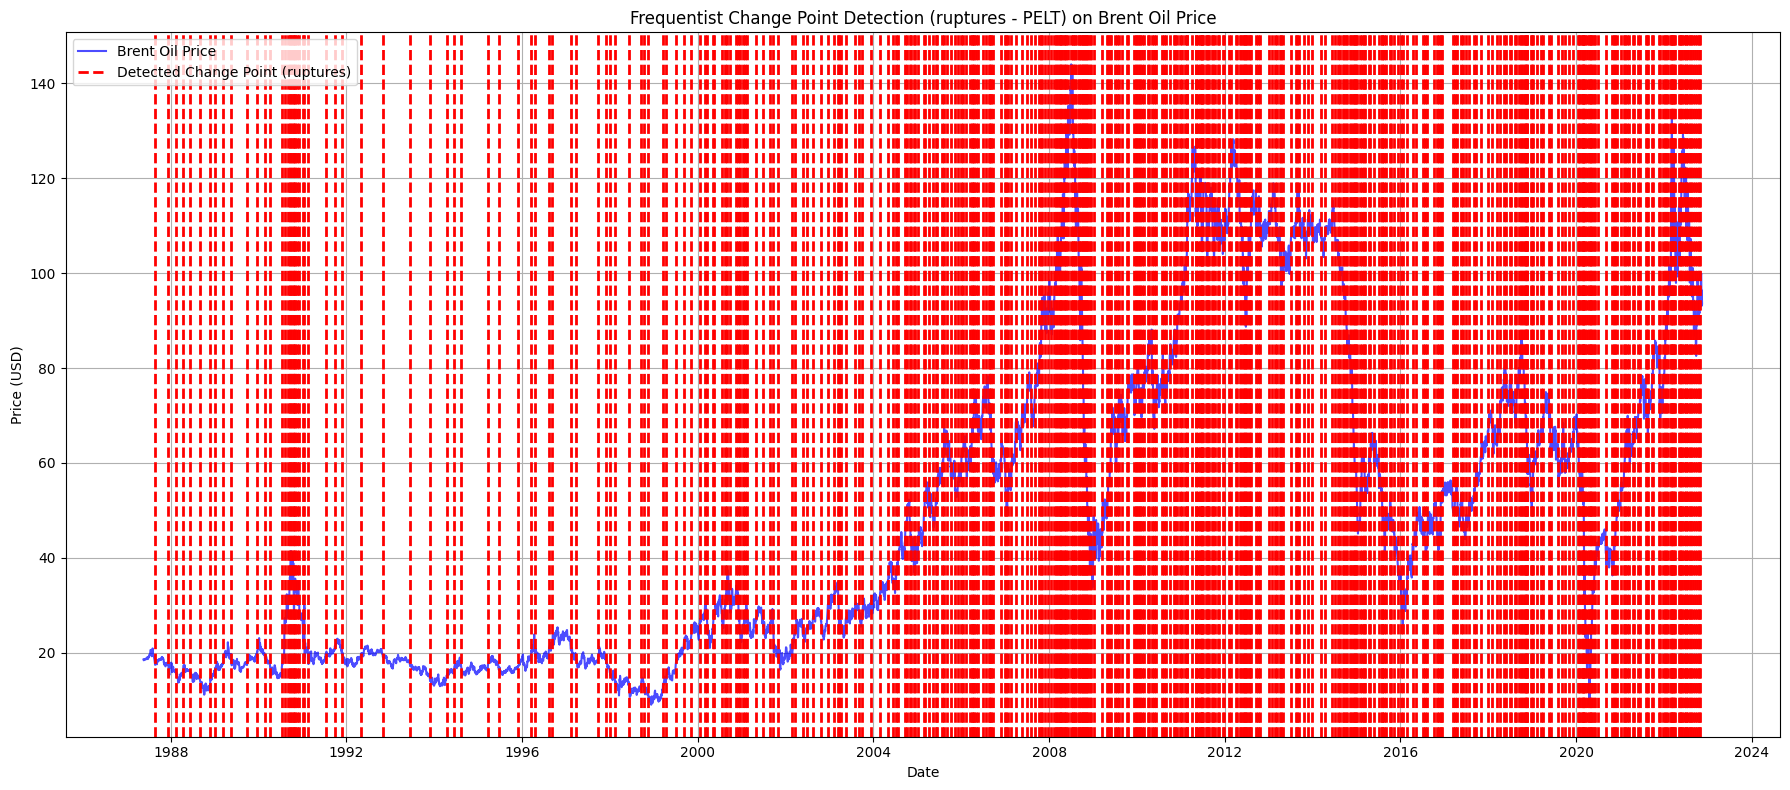

In [9]:
# Convert time series to a numpy array for the ruptures library
# We use the raw price data here to detect shifts in the mean price level.
if 'time_series_price' in locals() and not time_series_price.empty: # Check if time_series_price was successfully created and is not empty
    signal_array_ruptures = time_series_price.values.reshape(-1, 1) # Reshape for ruptures

    # Define the model and algorithm
    # 'l2' (L2 norm) cost function is good for detecting changes in mean.
    model_ruptures = "l2"
    algo_ruptures = rpt.Pelt(model=model_ruptures).fit(signal_array_ruptures)

    # Predict change points
    # The 'pen' (penalty) parameter controls the number of detected change points.
    # A higher penalty results in fewer change points.
    # You might need to tune this penalty for your specific dataset.
    # A common heuristic is 3 * log(n_samples) or 4 * log(n_samples).

    penalty_value_ruptures = 3 * np.log(len(time_series_price))
    change_points_ruptures = algo_ruptures.predict(pen=penalty_value_ruptures)

    # The 'ruptures' library returns the index of the last point of each segment.
    # We usually exclude the last point if it's just the end of the series.
    if change_points_ruptures and change_points_ruptures[-1] == len(time_series_price):
        detected_change_point_indices_ruptures = change_points_ruptures[:-1]
    else:
        detected_change_point_indices_ruptures = change_points_ruptures

    print(f"\nDetected Change Point Indices (ruptures on Price): {detected_change_point_indices_ruptures}")

    # Convert indices to dates for plotting
    detected_change_point_dates_ruptures = time_series_price.index[detected_change_point_indices_ruptures]
    print(f"Detected Change Point Dates (ruptures on Price): {detected_change_point_dates_ruptures.tolist()}")

    # Visualization for ruptures
    plt.figure(figsize=(18, 8))
    plt.plot(time_series_price.index, time_series_price.values, label='Brent Oil Price', color='blue', alpha=0.7)
    # Plot change points with labels, ensuring only one label is created for the legend
    for i, cp_date in enumerate(detected_change_point_dates_ruptures):
        plt.axvline(x=cp_date, color='red', linestyle='--', linewidth=2, label='Detected Change Point (ruptures)' if i == 0 else "")
    plt.title('Frequentist Change Point Detection (ruptures - PELT) on Brent Oil Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Frequentist Change Point Detection as price time series data is not available or empty.")

In [10]:
data.head()

,Price,Log_Return
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612
